<img align="right" src="https://raw.githubusercontent.com/GT4SD/gt4sd-core/main/docs/_static/gt4sd_logo.png" alt="logo" width="100" height="100"/>

# Demo: The Generative Toolkit for Scientific Discovery


In [1]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.QED import qed
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol
import pandas as pd
import mols2grid

### Let us have a look at a novel, AI-generated DDR1 kinase inhibitor

The following molecule is one of the first AI-generated molecules in drug discovery. It was demonstrated to have pharmacokinetic activity in mice. 
The molecule was proposed by the GENTRL algorithm, a variational autoencoder that was optimized with tensorial reinforcement learning (Zhavoronkov et al., 2019; _Nature Biotech_).

Throughout the tutorial, we will call the molecule 
- **gentrl_ddr1**

since it was developed to inhibit protein kinase DDR1.



For details on this molecule and its relation to already marketed drugs (e.g., Ponatinib), please see:

```txt
Zhavoronkov, A., Ivanenkov, Y. A., Aliper, A., Veselov, M. S., Aladinskiy, V. A., Aladinskaya, A. V., ... & Aspuru-Guzik, A. (2019). Deep learning enables rapid identification of potent DDR1 kinase inhibitors. Nature biotechnology, 37(9), 1038-1040.

Walters, W. P., & Murcko, M. (2020). Assessing the impact of generative AI on medicinal chemistry. Nature biotechnology, 38(2), 143-145.
```

In [2]:
gentrl_ddr1_smi = 'Cc1cc2ON=C(Nc3cccc(C(F)(F)F)c3)c2cc1C#Cc1cnc2cccnn12'
gentrl_ddr1_mol = Chem.MolFromSmiles(gentrl_ddr1_smi)
gentrl_ddr1_qed = qed(gentrl_ddr1_mol)
gentrl_ddr1_scaff = GetScaffoldForMol(gentrl_ddr1_mol)
gentrl_ddr1_scaff_smi = Chem.MolToSmiles(GetScaffoldForMol(gentrl_ddr1_mol))


mols2grid.display(
    pd.DataFrame({
        'SMILES': [gentrl_ddr1_smi], 'Name': ['gentrl_ddr1'], 'QED': [gentrl_ddr1_qed],
        'QED Val': [f'QED = {x:.3f}' for x in [gentrl_ddr1_qed]]
    }),
    size=(800,250), tooltip=['SMILES', 'Name', 'QED'], subset=['Name', 'img', 'QED Val']
)

# GT4SD Discovery usecase
## Find a similar molecule with improved drug-likeness

### **Goal:** 
The goal of this tutorial is to find a molecule that is **similar** to **gentrl_ddr1** but has a higher **drug-likeness** than it.

- We measure **similarity** with a structural similarity measure, the Tanimoto similarity of Morgan fingerprints (ECFP; *Rogers and Hahn, 2012*).
- We measure **drug-likeness** using the QED endpoint in `rdkit`.


NOTE: This is obviously is a highly artificial & simplistic discovery task but it gives us the opportunity to showcase many of the generative algorithms implemented in the GT4SD.



Import the algorithms and helper functions:

In [6]:
import logging, sys
logging.disable(sys.maxsize)
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

from gt4sd.algorithms.generation.moler import MoLeR, MoLeRDefaultGenerator
from gt4sd.algorithms.generation.torchdrug import TorchDrugGenerator, TorchDrugGCPN, TorchDrugGraphAF

from gt4sd.algorithms.conditional_generation.guacamol import GuacaMolGenerator, MosesGenerator
from gt4sd.algorithms.conditional_generation.guacamol import (
    VaeGenerator, AaeGenerator, OrganGenerator, GraphMCTSGenerator
)
from gt4sd.algorithms.conditional_generation.regression_transformer import (
    RegressionTransformer, RegressionTransformerMolecules
)
from tqdm import tqdm
from terminator.selfies import encoder
import pandas as pd
from rdkit.DataStructs import FingerprintSimilarity
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


## First attempt: 
Using unconditional molecular generative models that draw "random" samples from a learned chemical space

In [4]:

# Inititalize algorithms
moler_config = MoLeRDefaultGenerator()
moler_alg = MoLeR(configuration=moler_config)

organ_config = OrganGenerator()
organ_alg = GuacaMolGenerator(configuration=organ_config, target={})

vae_config = VaeGenerator()
vae_alg = GuacaMolGenerator(configuration=vae_config, target={})

aae_config = AaeGenerator()
aae_alg = GuacaMolGenerator(configuration=aae_config, target={})

gcpn_config = TorchDrugGCPN(algorithm_version='zinc250k_v0')
gcpn_alg = TorchDrugGenerator(configuration=gcpn_config)

graphaf_config = TorchDrugGraphAF(algorithm_version='zinc250k_v0')
graphaf_alg = TorchDrugGenerator(configuration=graphaf_config)

unconditional_algorithms = [moler_alg, organ_alg, vae_alg, aae_alg, gcpn_alg, graphaf_alg]
unconditional_names = ['MoLeR', 'ORGAN', 'VAE', 'AAE', 'GCPN', 'GraphAF']

# To compute similarity to our molecule
gentrl_ddr1_fp = GetMorganFingerprintAsBitVect(gentrl_ddr1_mol, radius=2)
get_tani = lambda x: FingerprintSimilarity(
    gentrl_ddr1_fp,
    GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), radius=2)
)

In [5]:
# Sample from the models (this will take a while)

num_samples = 100 # number of molecules sampled per model
mol_df = pd.DataFrame()
batch_size = 32

for model,name in tqdm(
    zip(unconditional_algorithms, unconditional_names), total=len(unconditional_algorithms),
    desc='Processing algorithm number:'
):
    smiles = []
    while len(smiles) < num_samples:
        smis = list(model.sample(batch_size))
        smiles.extend([s for s in smis if Chem.MolFromSmiles(s) and s not in smiles])
    mol_df = pd.concat([
        mol_df,
        pd.DataFrame({
            'smiles': smiles, 
            'algorithm': [name]*len(smiles), 
            'qed': list(map(lambda x: qed(Chem.MolFromSmiles(x)), smiles)),
            'similarity': list(map(get_tani, smiles))
        })
    ], axis=0
    )
mol_df = mol_df.reset_index()


Processing algorithm number::   0%|                                                                                                                                                                                                                       | 0/6 [00:00<?, ?it/s]

Loading a trained model from: /Users/jab/.gt4sd/algorithms/generation/MoLeR/MoLeRDefaultGenerator/v0/GNN_Edge_MLP_MoLeR__2022-02-24_07-16-23_best.pkl


2022-05-02 14:29:43.161821: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-02 14:29:43.167327: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-02 14:29:43.183715: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-02 14:29:43.205273: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-02 14:29:43.214015: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-02 14:29:43.222251: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa9fc1f5b10 initialized for platform 

Loading a trained model from: /Users/jab/.gt4sd/algorithms/generation/MoLeR/MoLeRDefaultGenerator/v0/GNN_Edge_MLP_MoLeR__2022-02-24_07-16-23_best.pkl


2022-05-02 14:29:56.073984: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-02 14:29:56.073890: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-02 14:29:56.079276: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-02 14:29:56.087910: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-02 14:29:56.097321: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-02 14:29:56.102712: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFl

Loading a trained model from: /Users/jab/.gt4sd/algorithms/generation/MoLeR/MoLeRDefaultGenerator/v0/GNN_Edge_MLP_MoLeR__2022-02-24_07-16-23_best.pkl


2022-05-02 14:30:08.111470: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-02 14:30:08.114600: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-02 14:30:08.126189: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-02 14:30:08.140320: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-02 14:30:08.146719: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-02 14:30:08.157512: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa9fc6c8050 initialized for platform 

Loading a trained model from: /Users/jab/.gt4sd/algorithms/generation/MoLeR/MoLeRDefaultGenerator/v0/GNN_Edge_MLP_MoLeR__2022-02-24_07-16-23_best.pkl


2022-05-02 14:30:20.637455: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-02 14:30:20.641384: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-02 14:30:20.648936: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-02 14:30:20.655614: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-02 14:30:20.662043: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-02 14:30:20.670439: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFl


Generating mols: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 45.82it/s]

Generating mols: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 45.60it/s]

Generating mols: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 45.62it/s]

Generating mols: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Text(0.5, 1.0, 'Similarity of generated molecules (n=100 per model)')

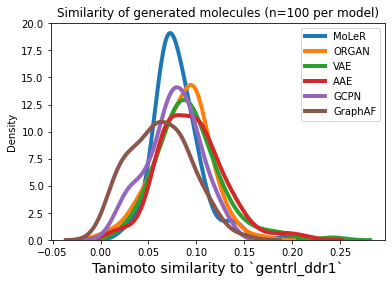

In [108]:
# Plot Tanimoto similarity per model
for model in mol_df.algorithm.unique():
    tdf = mol_df[mol_df.algorithm==model]
    sns.distplot(tdf['similarity'], label=model, hist=False, kde_kws={'linewidth':4})
    
plt.legend()
plt.xlabel('Tanimoto similarity to `gentrl_ddr1`', size=14)
plt.title(f'Similarity of generated molecules (n={num_samples} per model)')

Text(0.5, 1.0, 'QED of generated molecules (n=100 per model)')

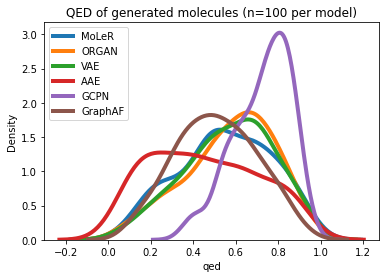

In [119]:
# Plot QED per model
for model in mol_df.algorithm.unique():
    tdf = mol_df[mol_df.algorithm==model]
    sns.distplot(tdf['qed'], label=model, hist=False, kde_kws={'linewidth':4})
    
plt.legend()
plt.title(f'QED of generated molecules (n={num_samples} per model)')

Text(32.698506944444446, 0.5, 'Tanimoto similarity')

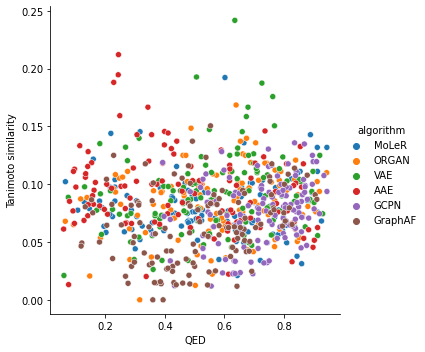

In [298]:
sns.relplot(data=mol_df, x='qed', y='similarity', hue='algorithm')
plt.xlabel('QED')
plt.ylabel('Tanimoto similarity')


####  We can see that the GCPN model generates molecules with the highest drug-likeness score. Moreover, the molecules generated by the AAE have the highest similarity to **gentrl_ddr1* compared to the molecules of the other models. 

#### Let us have a look at the best molecule per model

In [271]:
best_mols = pd.concat([
    mol_df[(mol_df.algorithm==model) & (mol_df.qed>gentrl_ddr1_qed)].sort_values(
        by='similarity', ascending=False
    ).head(1)
    for model in mol_df.algorithm.unique()
]).sort_values(by='similarity', ascending=False)
best_mols['text'] = best_mols.apply(lambda x: f"Tanimoto={x['similarity']:.2f} (QED={x['qed']:.2f})", axis=1)
mols2grid.display(
    best_mols, smiles_col='smiles', n_cols=len(best_mols)//2,
    size=(300,200), tooltip=['smiles', 'algorithm', 'qed', 'similarity'], subset=['algorithm', 'img', 'text']
)


#### Unfortunately, a Tanimoto similarity of 0.21 cannot be considered anyhow similar. Therefore, we should try more controllable generative models.

## Second attempt: 
Using conditional molecular generative models that sample from a structure-constrained or property-driven learned chemical space

In [7]:
# Conditional approaches
from gt4sd.algorithms.conditional_generation.reinvent import Reinvent, ReinventGenerator
from terminator.selfies import encoder, split_selfies

# Inititalize algorithms

reinvent_config = ReinventGenerator()
reinvent_alg = Reinvent(configuration=reinvent_config, target=gentrl_ddr1_smi)


moler_config = MoLeRDefaultGenerator(scaffolds=gentrl_ddr1_smi)
moler_alg = MoLeR(configuration=moler_config)

moler_config_scaff = MoLeRDefaultGenerator(scaffolds=gentrl_ddr1_scaff_smi)
moler_alg_scaff = MoLeR(configuration=moler_config_scaff)

conditional_algorithms = [reinvent_alg, moler_alg, moler_alg_scaff]
conditional_names = ['ReInvent', 'MoLeR', 'MoLeR Scaff.']


"""
Set up the Regression Transformer.

This is a bit more involved since it is a local (substructe-based) generative model and we explicitly have to
tell the model which parts of the molecule are fixed and which are flexible. We therefore create multiple
configurations where we randomly mask atoms & bonds.

"""
def mask_selfies(s:str, p:float)->str:
    pre, post = s.split('|')
    tokens = [t if np.random.sample() > p else '[MASK]' for t in split_selfies(post)]
    return pre + '|' + '' .join(tokens)


rt_attempts = 20
rt_samples = 5
rt_maskprob = [0.1, 0.5]

gentrl_ddr1_selfies = encoder(gentrl_ddr1_smi)
gentrl_ddr1_selfies_rt = '<qed>0.798|'+gentrl_ddr1_selfies

rt_config = RegressionTransformerMolecules(
    algorithm_version='qed', search='sample', temperature=1.5, tolerance=60
)
rt_algs = []
for i in range(rt_attempts):
    rt_input = mask_selfies(gentrl_ddr1_selfies_rt, np.random.uniform(*rt_maskprob))
    rt_algs.append(RegressionTransformer(configuration=rt_config, target=rt_input))
    

In [8]:
# Sample from the models (this will take a while)

cg_mol_df = pd.DataFrame()
batch_size = 32
num_samples = 100


for model,name in tqdm(
    zip(conditional_algorithms, conditional_names), total=len(conditional_names),
    desc='Processing algorithm number:'
):
    smiles = []
    while len(smiles) < num_samples:
        smis = list(model.sample(batch_size))
        smiles.extend([s for s in smis if Chem.MolFromSmiles(s) and s not in smiles])
    cg_mol_df = pd.concat([
        cg_mol_df,
        pd.DataFrame({
            'smiles': smiles, 
            'algorithm': [name]*len(smiles), 
            'qed': list(map(lambda x: qed(Chem.MolFromSmiles(x)), smiles)),
            'similarity': list(map(get_tani, smiles))
        })
    ], axis=0
    )

# Now run the Regression Transformer configurations
rt_smiles = set()
for model in tqdm(rt_algs, total=len(rt_algs), desc='Processing RT number:'):
    smiles = set()
    while len(smiles) < rt_samples:
        smiles = smiles.union([s[0] for s in list(model.sample(rt_samples)) if s[0] not in rt_smiles])
    rt_smiles.union(smiles)
    cg_mol_df = pd.concat([
        cg_mol_df,
        pd.DataFrame({
            'smiles': list(smiles), 
            'algorithm': ['RegressionTransformer']*len(smiles), 
            'qed': list(map(lambda x: qed(Chem.MolFromSmiles(x)), smiles)),
            'similarity': list(map(get_tani, smiles))
        })
    ], axis=0
    )

# Remove re-generations of original molecule and add seed
cg_mol_df = cg_mol_df.reset_index()
cg_mol_df = cg_mol_df[cg_mol_df.similarity<1]
cg_mol_df

Processing algorithm number::  33%|█████████████████████████████████████████████████████████████████████                                                                                                                                          | 1/3 [00:39<01:18, 39.11s/it]

Loading a trained model from: /Users/jab/.gt4sd/algorithms/generation/MoLeR/MoLeRDefaultGenerator/v0/GNN_Edge_MLP_MoLeR__2022-02-24_07-16-23_best.pkl


2022-05-03 13:35:08.657965: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:35:08.669286: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:35:08.671305: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:35:08.679694: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:35:08.684807: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:35:08.682192: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFl

Loading a trained model from: /Users/jab/.gt4sd/algorithms/generation/MoLeR/MoLeRDefaultGenerator/v0/GNN_Edge_MLP_MoLeR__2022-02-24_07-16-23_best.pkl


2022-05-03 13:35:35.833371: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:35:35.842806: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:35:35.857801: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:35:35.869579: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:35:35.877047: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:35:35.889029: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFl

Loading a trained model from: /Users/jab/.gt4sd/algorithms/generation/MoLeR/MoLeRDefaultGenerator/v0/GNN_Edge_MLP_MoLeR__2022-02-24_07-16-23_best.pkl


2022-05-03 13:35:50.303230: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:35:50.303372: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:35:50.313332: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:35:50.336147: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:35:50.357256: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:35:50.376255: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7faae586a120 initialized for platform 

Loading a trained model from: /Users/jab/.gt4sd/algorithms/generation/MoLeR/MoLeRDefaultGenerator/v0/GNN_Edge_MLP_MoLeR__2022-02-24_07-16-23_best.pkl


2022-05-03 13:36:07.722238: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:36:07.733710: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:36:07.746376: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:36:07.764812: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:36:07.780061: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:36:07.788062: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fab7e9adda0 initialized for platform 

Loading a trained model from: /Users/jab/.gt4sd/algorithms/generation/MoLeR/MoLeRDefaultGenerator/v0/GNN_Edge_MLP_MoLeR__2022-02-24_07-16-23_best.pkl


2022-05-03 13:36:24.004495: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:36:24.015688: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:36:24.036399: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:36:24.056044: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:36:24.065753: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7faae58598f0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-03 13:36:24.066612: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host

Loading a trained model from: /Users/jab/.gt4sd/algorithms/generation/MoLeR/MoLeRDefaultGenerator/v0/GNN_Edge_MLP_MoLeR__2022-02-24_07-16-23_best.pkl


2022-05-03 13:36:40.560882: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:36:40.572404: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:36:40.584268: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:36:40.602034: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:36:40.611643: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fab4348c4e0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-03 13:36:40.612462: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host

Loading a trained model from: /Users/jab/.gt4sd/algorithms/generation/MoLeR/MoLeRDefaultGenerator/v0/GNN_Edge_MLP_MoLeR__2022-02-24_07-16-23_best.pkl


2022-05-03 13:36:55.161227: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:36:55.174039: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:36:55.195232: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:36:55.213014: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fab7e99c080 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-03 13:36:55.213859: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-05-03 13:36:55.216191: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled

Loading a trained model from: /Users/jab/.gt4sd/algorithms/generation/MoLeR/MoLeRDefaultGenerator/v0/GNN_Edge_MLP_MoLeR__2022-02-24_07-16-23_best.pkl


2022-05-03 13:37:12.134801: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:37:12.152515: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:37:12.174966: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:37:12.189662: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:37:12.206168: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fab7eaaf5d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-03 13:37:12.208051: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host

Loading a trained model from: /Users/jab/.gt4sd/algorithms/generation/MoLeR/MoLeRDefaultGenerator/v0/GNN_Edge_MLP_MoLeR__2022-02-24_07-16-23_best.pkl


2022-05-03 13:37:25.606578: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:37:25.619746: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:37:25.637560: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:37:25.647868: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:37:25.660234: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fab7ea61fc0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-03 13:37:25.661265: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host

Loading a trained model from: /Users/jab/.gt4sd/algorithms/generation/MoLeR/MoLeRDefaultGenerator/v0/GNN_Edge_MLP_MoLeR__2022-02-24_07-16-23_best.pkl


2022-05-03 13:37:41.958916: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:37:41.959492: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:37:41.980112: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:37:41.999534: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:37:42.020391: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-03 13:37:42.026249: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fab7d57deb0 initialized for platform 

,index,smiles,algorithm,qed,similarity
0,0,C1CCN(CCN2CCC(c3nc(C(C)C)no3)(C3CC3)CC2)C1CN(C...,ReInvent,0.060025,0.067265
1,1,C1COCCN1CCCOC(=O)C1CN(C)CCN1CC(C)(C)CN*,ReInvent,0.459575,0.046296
2,2,C1N(CCCCN2CCN(CCOC)CC2)CCC1N(C)CC1SCCN1CC1(CO)...,ReInvent,0.046893,0.049774
3,3,C1C(C(C)NC(=O)OC2CCN(CC)CC2)CCN(C(=O)c2ccc(CN(...,ReInvent,0.155778,0.047619
4,4,C1N(CC2CC2)CCC1CN(CC)CCNC(=O)c1cc(C(F)(F)F)cc(...,ReInvent,0.263800,0.137097
...,...,...,...,...,...
472,1,CNNC2=CN=C(CC1=CC=CC(C(F)(F)F)=C1C)CC=C2CNC3=C...,RegressionTransformer,0.428104,0.148148
473,2,O=C=NCNN=C(NC1=CC=CC(C(F)(F)F)N1)C=CC#N,RegressionTransformer,0.173878,0.066667
474,3,O(N)N=C(NC1=CC=CC(C(F)(F)F)=C1)C=CCNC2=CC=C3C=...,RegressionTransformer,0.334837,0.191919
475,4,N(C=O)C(F)(F)F,RegressionTransformer,0.383003,0.056338


Text(0.5, 1.0, 'Similarity of generated molecules (n=100 per model)')

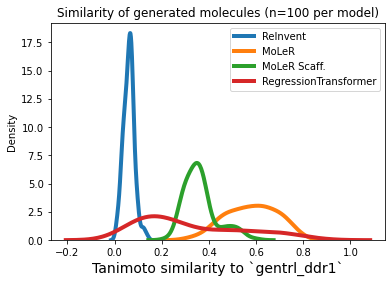

In [9]:
# Plot again the Tanimoto similarity per model
for model in cg_mol_df.algorithm.unique():
    tdf = cg_mol_df[cg_mol_df.algorithm==model]
    sns.distplot(tdf['similarity'], label=model, hist=False, kde_kws={'linewidth':4})
    
plt.legend()
plt.xlabel('Tanimoto similarity to `gentrl_ddr1`', size=14)
plt.title(f'Similarity of generated molecules (n={num_samples} per model)')

### While the Reinvent molecules are generally not similar to **gentrl_ddr1**, the other 3 methods all managed to generate some molecules with reasonable similarity to the seed. Overall, the MoLeR molecules had the highest average similarity. But how about their drug-likeness?

Text(0.5, 1.0, 'QED of generated molecules (n=100 per model)')

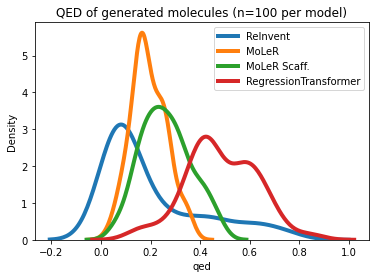

In [22]:
# Plot QED per model
for model in cg_mol_df.algorithm.unique():
    tdf = cg_mol_df[cg_mol_df.algorithm==model]
    sns.distplot(tdf['qed'], label=model, hist=False, kde_kws={'linewidth':4})
    
plt.legend()
plt.title(f'QED of generated molecules (n={num_samples} per model)')

### Here we can see that the molecules from the RegressionTransformer had the highest drug-likeness scores. 
### The MoLeR molecules mostly had QED values similar to the seed molecule.
### Overall, these molecules are already much more similar to **gentrl_ddr1** than the ones from the unconditional models.
## Now, let's have a look which model and molecules fullfil both constraints (high similarity to the seed and an improved QED)

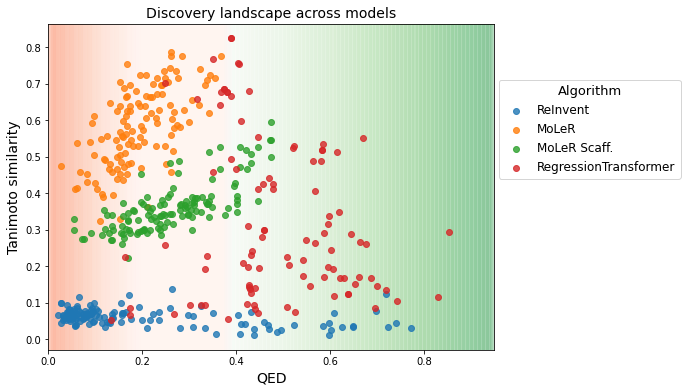

In [23]:
import matplotlib.cm as cm
num_steps = 200

fig, ax = plt.subplots(figsize=(8,6))

# Green shade for desired QED area
steps = np.linspace(gentrl_ddr1_qed, 0.95, num_steps)
for i in range(num_steps-1):
    color = cm.Greens(min(i/(num_steps+100), (num_steps+100)))
    ax.axvspan(steps[i]+0.01, steps[i+1]-0.01, alpha=0.1, color=color)
    
# Red shade for undesired QED area
steps = np.linspace(0, gentrl_ddr1_qed, num_steps)
for i in range(num_steps-1, 0, -1):
    color = cm.Reds(min((100-i)/(num_steps+100), (num_steps+100)))
    ax.axvspan(steps[i-1]+0.01, steps[i]-0.01, alpha=0.1, color=color)
    
    
colors = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
for m in cg_mol_df.algorithm.unique():
    tdf = cg_mol_df[cg_mol_df.algorithm==m]
    plt.scatter(tdf['qed'], tdf['similarity'], color=next(colors), label=m, alpha=0.8)
plt.xlabel('QED', size=14)
plt.ylabel('Tanimoto similarity', size=14)
plt.legend(loc=[1.01, 0.525], prop={'size': 12}, title='Algorithm', title_fontsize=13)
plt.xlim([0, 0.95])
plt.title('Discovery landscape across models', size=14)
plt.savefig('gentrl_ddr1_scatterplot.pdf')

### The ideal area is the top right corner of the plot. Of course, there is a trade-off in that very similar molecules to *gentrl_ddr1* will not induce large changes in the drug-likeness since QED is a synthetic score where "score cliffs" in the chemical space are rare. 

## Let's display the best identified molecules (per method). To define "goodness" we use a score that is based to 60% on Tanimoto similarity and 40% on QED

In [45]:
cg_mol_df['score'] = cg_mol_df.apply(lambda x: x.similarity+x.qed/1.5, axis=1)

best_mols = pd.concat([
    cg_mol_df[(cg_mol_df.algorithm==model) & (cg_mol_df.qed>gentrl_ddr1_qed-0.02)].sort_values(
        by='score', ascending=False
    ).head(1)
    for model in cg_mol_df.algorithm.unique()
]).sort_values(by='similarity', ascending=False)
best_mols = pd.concat([
    pd.DataFrame({'smiles': gentrl_ddr1_smi, 'algorithm': r"SEED (Gentrl-DDR1)", 'qed': gentrl_ddr1_qed, 'similarity': 1.0}, index=[0]),
    best_mols
])
best_mols['text'] = best_mols.apply(lambda x: f"Tanimoto={x['similarity']:.2f} (QED={x['qed']:.2f})", axis=1)
mols2grid.display(
    best_mols, smiles_col='smiles', n_cols=3,
    size=(300,200), tooltip=['smiles', 'algorithm', 'qed', 'similarity'], subset=['algorithm', 'img', 'text']
)


### Both, MoLeR and the RegressionTransformer generate reasonably similar molecules to the *gentrl-ddr1*. 
### Let's plot the best molecules (Tanimoto similarity >0.5 with improved QED)

In [47]:
cg_mol_df['score'] = cg_mol_df.apply(lambda x: x.similarity+x.qed/1.5, axis=1)

best_mols = cg_mol_df[(cg_mol_df.similarity>0.5) & (cg_mol_df.qed>gentrl_ddr1_qed)].drop_duplicates(
    subset='smiles'
).sort_values(by='score', ascending=False)
best_mols = pd.concat([
    pd.DataFrame({'smiles': gentrl_ddr1_smi, 'algorithm': r"SEED (Gentrl-DDR1)", 'qed': gentrl_ddr1_qed, 'similarity': 1.0}, index=[0]),
    best_mols
])
best_mols['text'] = best_mols.apply(lambda x: f"Tanimoto={x['similarity']:.2f} (QED={x['qed']:.2f})", axis=1)
mols2grid.display(
    best_mols, smiles_col='smiles', n_cols=5, n_rows=10,
    size=(200,150), tooltip=['smiles', 'algorithm', 'qed', 'similarity'], subset=['algorithm', 'img', 'text']
)


### The most similar molecules with improved QED were generated by the RegressionTransformer. However the RT molecules tend to be limited to very subtle modifications of the initial molecule. 
### Instead, the MoLeR molecules are slightly more versatile. But their vast majority does not respect the QED improvement constraint.

# In sum, we have seen that the GT4SD seamlessly integrates the access to a rich set of molecular generative models. All investigated models have different strengths and weaknesses that need to be considered when choosing one or multiple generative models for a real discovery task.